# Download images of motorcycles and bicycles

In [3]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(keywords, max_images = 30):
    print(f"Searching for {keywords}")
    return L(DDGS().images(keywords,max_results=max_images)).itemgot('image')

In [4]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('motorcycle photos', max_images=1)
urls[0]

Searching for motorcycle photos


'https://wallpapercave.com/wp/BYhRCkz.jpg'

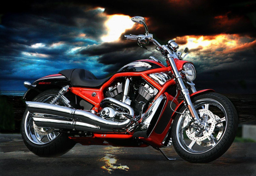

In [5]:
from fastdownload import download_url
dest = 'motorcycle.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for bicycle photos


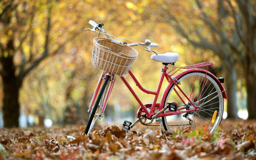

In [6]:
download_url(search_images('bicycle photos', max_images=1)[0], 'bicycle.jpg', show_progress=False)
Image.open('bicycle.jpg').to_thumb(256,256)

In [7]:
# Gather and store a few examples of bicycles and motorcycle then save each group of photos to a different folder

searches = 'bicycle','motorcycle'
path = Path('motorcycle_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for bicycle photo
Searching for bicycle sun photo
Searching for bicycle shade photo
Searching for motorcycle photo
Searching for motorcycle sun photo
Searching for motorcycle shade photo


# Train the model

In [8]:
# Remove any failed images

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

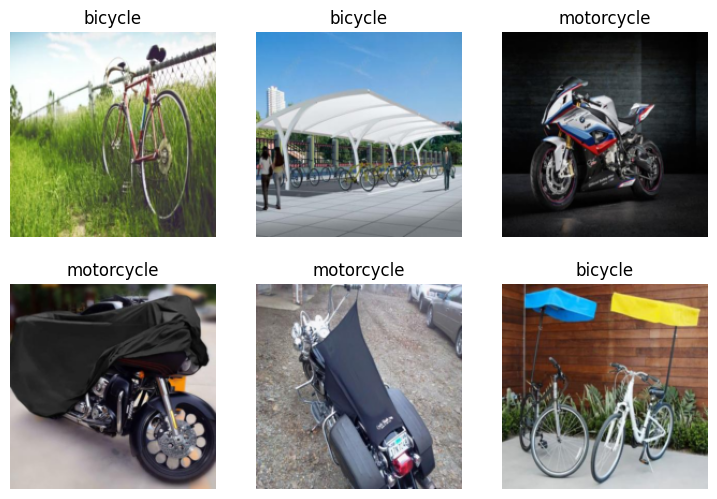

In [11]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [12]:
# Fine tune the model

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 30.1MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.866975,0.104878,0.019802,00:45


epoch,train_loss,valid_loss,error_rate,time
0,0.145268,0.083116,0.009901,01:06
1,0.149882,0.085366,0.009901,01:07
2,0.115075,0.088689,0.009901,00:52


In [15]:
is_bicycle,_,probs = learn.predict(PILImage.create('bicycle.jpg'))
print(f"This is a: {is_bicycle}.")
print(f"Probability it's a bicycle: {probs[0]:.4f}")

This is a: bicycle.
Probability it's a bicycle: 0.9999
